In [10]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score



In [11]:
# Cell 2: Load datasets
df_train = pd.read_csv('data/cleaned_train (4).csv')
df_test = pd.read_csv('data/cleaned_test (6).csv')

In [12]:
# Cell 3: Separate features and target
X_train = df_train.drop('Churn', axis=1)
y_train = df_train['Churn']
X_test = df_test.drop('Churn', axis=1)
y_test = df_test['Churn']


In [13]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier


models = {
    'GBM': GradientBoostingClassifier(
        n_estimators=100, 
        learning_rate=0.1, 
        max_depth=3, 
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        max_depth=None, 
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100, 
        learning_rate=0.1, 
        max_depth=3, 
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        random_state=42
    ),
    'SVM': SVC(
        kernel='rbf', 
        probability=True, 
        random_state=42
    ),
    
    'AdaBoost': AdaBoostClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    ),
    
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=42
    ),
    
    'CatBoost': CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=3,
        random_state=42,
        verbose=False
    ),
    
    'Stacking': StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('xgb', XGBClassifier(n_estimators=100, random_state=42))
        ],
        final_estimator=LogisticRegression(),
        cv=5
    )
}

In [14]:
# Cell 5: Create evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Print results
    print(f"\nResults for {model_name}:")
    print("-" * 50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return accuracy, roc_auc, y_pred, y_pred_proba


In [15]:
# Cell 6: Train and evaluate all models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"{name} Cross-validation ROC-AUC scores: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Evaluate on test set
    accuracy, roc_auc, y_pred, y_pred_proba = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    results[name] = {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }


Training GBM...
GBM Cross-validation ROC-AUC scores: 0.8600 (+/- 0.1052)

Results for GBM:
--------------------------------------------------
Accuracy: 0.9150
ROC-AUC Score: 0.8816

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.97      0.95       553
        True       0.76      0.61      0.67        94

    accuracy                           0.91       647
   macro avg       0.85      0.79      0.81       647
weighted avg       0.91      0.91      0.91       647


Training Random Forest...
Random Forest Cross-validation ROC-AUC scores: 0.8419 (+/- 0.0838)

Results for Random Forest:
--------------------------------------------------
Accuracy: 0.9042
ROC-AUC Score: 0.8584

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.95      0.94       553
        True       0.69      0.62      0.65        94

    accuracy                           0.90       647
   macro avg 

<Figure size 1000x600 with 0 Axes>

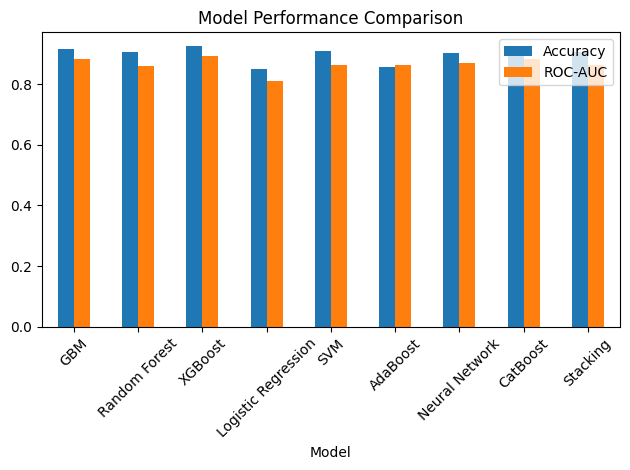

In [16]:
# Cell 7: Compare model performances
performance_df = pd.DataFrame({
    'Model': results.keys(),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'ROC-AUC': [results[model]['roc_auc'] for model in results]
})

plt.figure(figsize=(10, 6))
performance_df.plot(x='Model', y=['Accuracy', 'ROC-AUC'], kind='bar')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Training GBM...
Training Random Forest...
Training XGBoost...
Training Logistic Regression...
Training SVM...
Training AdaBoost...
Training Neural Network...
Training CatBoost...
Training Stacking...


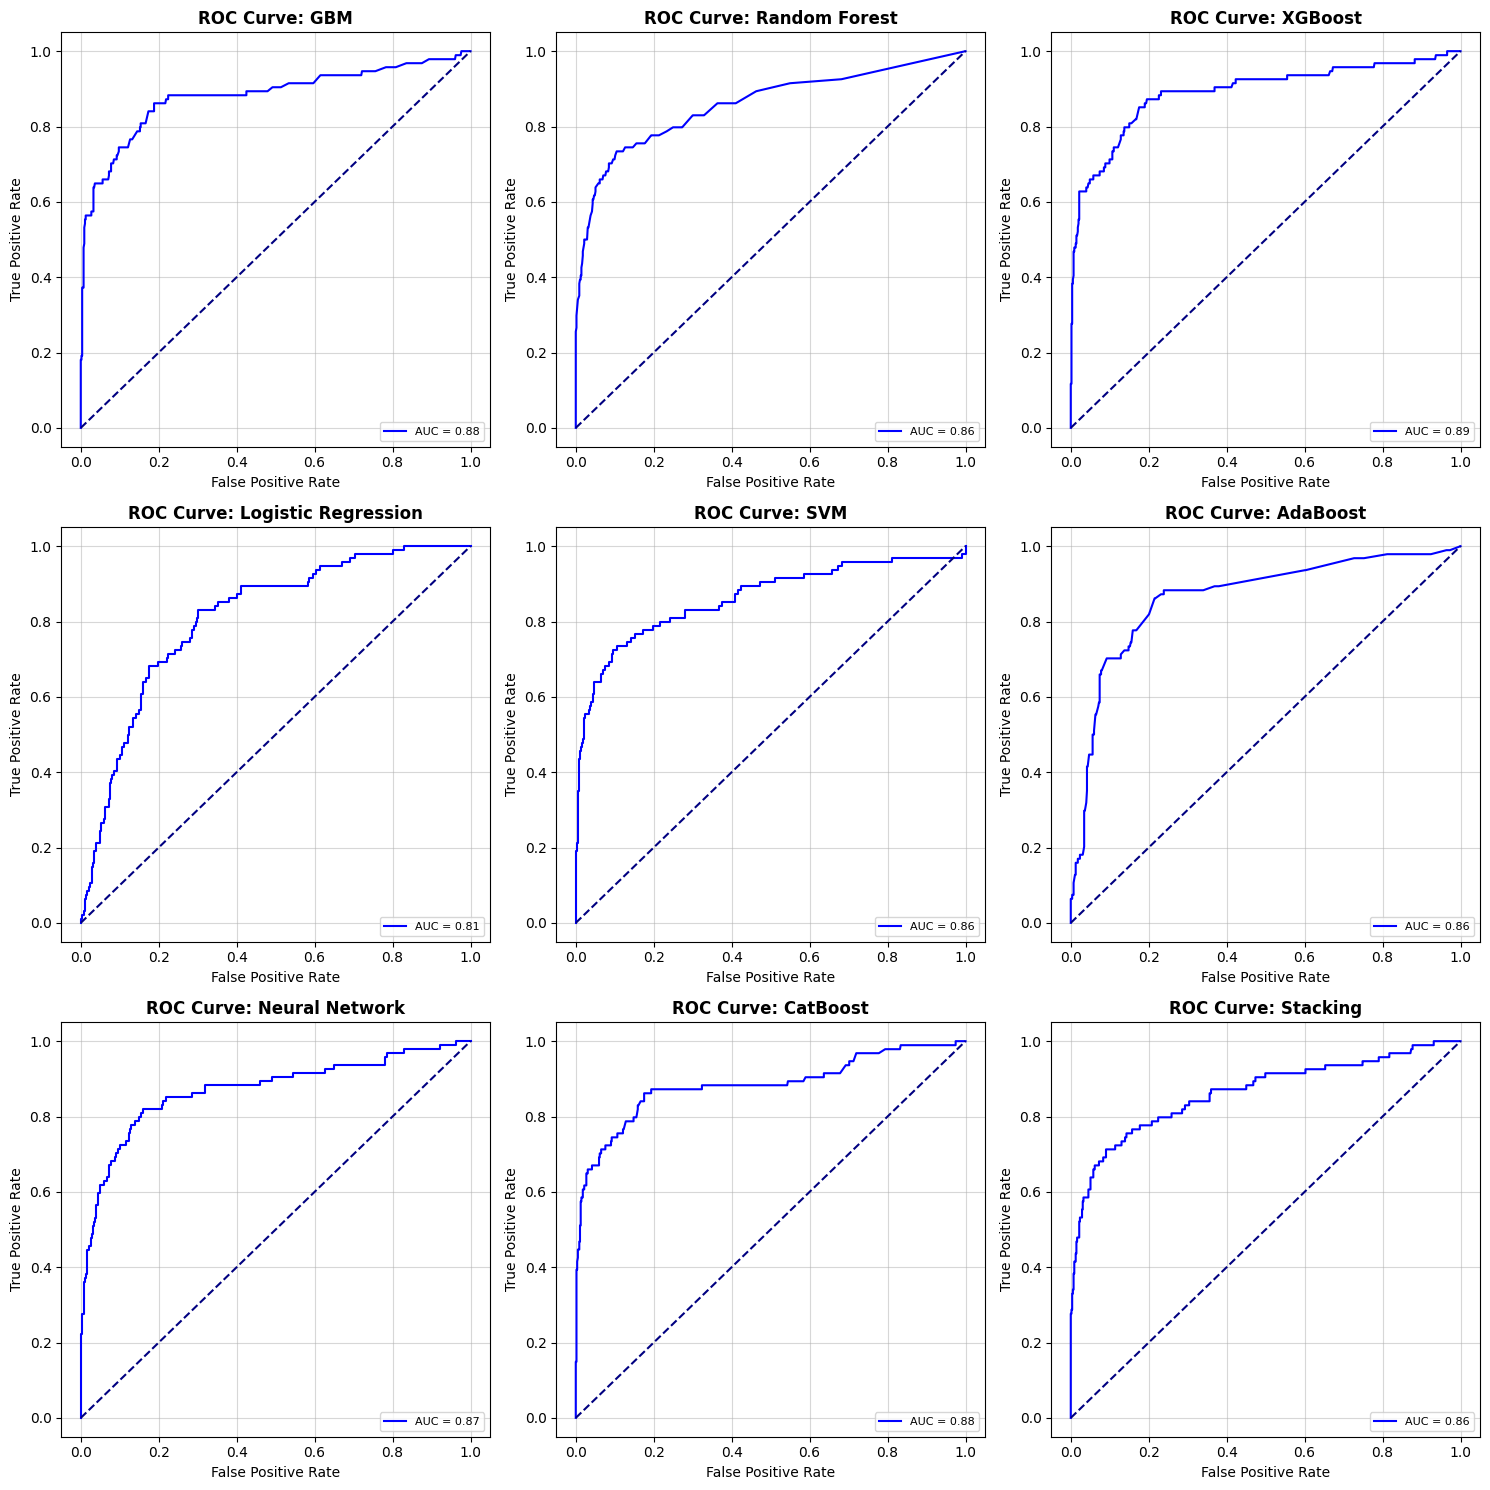

In [17]:
from sklearn.metrics import roc_curve, auc
import math

# Function to plot ROC-AUC curves side by side or in a grid
def plot_roc_auc_grid(models, X_train, y_train, X_test, y_test):
    n_models = len(models)
    n_cols = 3  # Number of columns in the grid
    n_rows = math.ceil(n_models / n_cols)  # Determine number of rows based on the number of models

    # Create a figure for the grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    for i, (model_name, model) in enumerate(models.items()):
        print(f"Training {model_name}...")
        model.fit(X_train, y_train)  # Train the model
        
        # Check if the model supports probability predictions
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_pred_proba = model.decision_function(X_test)
        else:
            print(f"Skipping {model_name}: No probability predictions available.")
            continue
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve on the appropriate subplot
        ax = axes[i]
        ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='b')
        ax.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Diagonal line
        ax.set_title(f"ROC Curve: {model_name}", fontsize=12, fontweight="bold")
        ax.set_xlabel("False Positive Rate", fontsize=10)
        ax.set_ylabel("True Positive Rate", fontsize=10)
        ax.legend(loc="lower right", fontsize=8)
        ax.grid(alpha=0.5)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the function to plot ROC-AUC curves
plot_roc_auc_grid(models, X_train, y_train, X_test, y_test)

In [18]:

# Cell 8: Print final comparison table
print("\nFinal Model Performance Comparison:")
print(performance_df.sort_values('ROC-AUC', ascending=False))


Final Model Performance Comparison:
                 Model  Accuracy   ROC-AUC
2              XGBoost  0.924266  0.891116
7             CatBoost  0.921175  0.883729
0                  GBM  0.914992  0.881565
6       Neural Network  0.902628  0.869993
5             AdaBoost  0.854714  0.863664
8             Stacking  0.907264  0.863078
4                  SVM  0.908810  0.861298
1        Random Forest  0.904173  0.858422
3  Logistic Regression  0.850077  0.809453


In [19]:

# Function to perform grid search and evaluation
def perform_grid_search(model, param_grid, model_name):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=5,
        verbose=1,
        n_jobs=-1
    )
    
    print(f"\nPerforming grid search for {model_name}...")
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    print(f"\nBest Parameters for {model_name}:")
    print(grid_search.best_params_)
    print(f"\n{model_name} Performance:")
    print("-" * 50)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return best_model, grid_search.best_score_


In [20]:
optimized_models = {
    'GBM': GradientBoostingClassifier(
        n_estimators=100, 
        learning_rate=0.05, 
        max_depth=3, 
        subsample=1.0, 
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=80, 
        max_depth=10, 
        max_features='sqrt', 
        min_samples_split=5, 
        min_samples_leaf=2, 
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=120, 
        learning_rate=0.1, 
        max_depth=3, 
        min_child_weight=5, 
        subsample=0.9, 
        colsample_bytree=0.8, 
        random_state=42
    ),
    'CatBoost': CatBoostClassifier(
        iterations=100, 
        depth=3, 
        learning_rate=0.12, 
        l2_leaf_reg=3, 
        subsample=0.9, 
        random_state=42, 
        verbose=0
    ),
    'Stacking': StackingClassifier(
        estimators=[
            ('rf-estimator', RandomForestClassifier(n_estimators=80, max_depth=10, random_state=42)),
            ('xgb-estimator', XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
        ],
        final_estimator=None,  # Optionally set a meta-learner, e.g., LogisticRegression()
        passthrough=False,    # Whether to pass original features to the meta-learner
        cv=5                  # Cross-validation for stacking
    )
}

In [21]:
import warnings
from sklearn.model_selection import cross_val_score

# Specific warning suppressions
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=Warning)

# Additional specific suppressions for LightGBM
warnings.filterwarnings('ignore', message='.*found whitespace in feature_names.*')
warnings.filterwarnings('ignore', message='.*categorical_feature in param dict is overridden.*')
warnings.filterwarnings("ignore", message=".*Valid features.*")

# Train and evaluate all optimized models
results = {}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # Suppress all warnings within this block
    for name, model in optimized_models.items():
        print(f"\nTraining {name}...")
        
        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        print(f"{name} Cross-validation ROC-AUC scores: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Evaluate on test set
        accuracy, roc_auc, y_pred, y_pred_proba = evaluate_model(model, X_train, y_train, X_test, y_test, name)
        results[name] = {
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }


Training GBM...
GBM Cross-validation ROC-AUC scores: 0.8638 (+/- 0.1084)

Results for GBM:
--------------------------------------------------
Accuracy: 0.9243
ROC-AUC Score: 0.8802

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.98      0.96       553
        True       0.82      0.62      0.70        94

    accuracy                           0.92       647
   macro avg       0.88      0.80      0.83       647
weighted avg       0.92      0.92      0.92       647


Training Random Forest...
Random Forest Cross-validation ROC-AUC scores: 0.8689 (+/- 0.0717)

Results for Random Forest:
--------------------------------------------------
Accuracy: 0.9196
ROC-AUC Score: 0.8883

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.97      0.95       553
        True       0.78      0.63      0.69        94

    accuracy                           0.92       647
   macro avg 

<Figure size 1000x600 with 0 Axes>

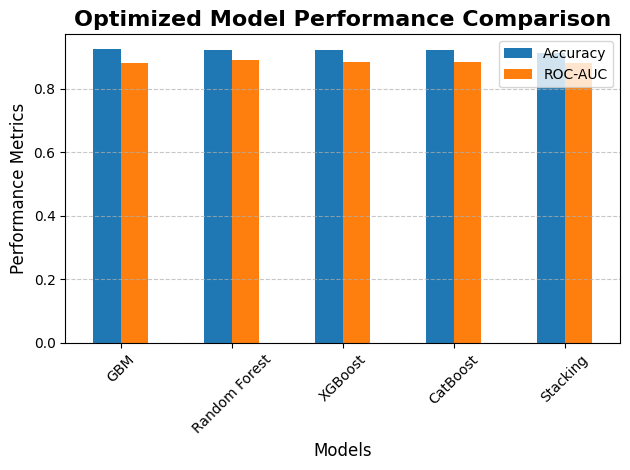

In [22]:
# Create a DataFrame for results
performance_df = pd.DataFrame({
    'Model': results.keys(),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'ROC-AUC': [results[model]['roc_auc'] for model in results]
})

# Plotting the performance
plt.figure(figsize=(10, 6))
performance_df.set_index('Model')[['Accuracy', 'ROC-AUC']].plot(
    kind='bar'
)

# Add titles and labels
plt.title('Optimized Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Performance Metrics', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(loc='best', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Training GBM...
Training Random Forest...
Training XGBoost...
Training Logistic Regression...
Training SVM...
Training AdaBoost...
Training Neural Network...
Training CatBoost...
Training Stacking...


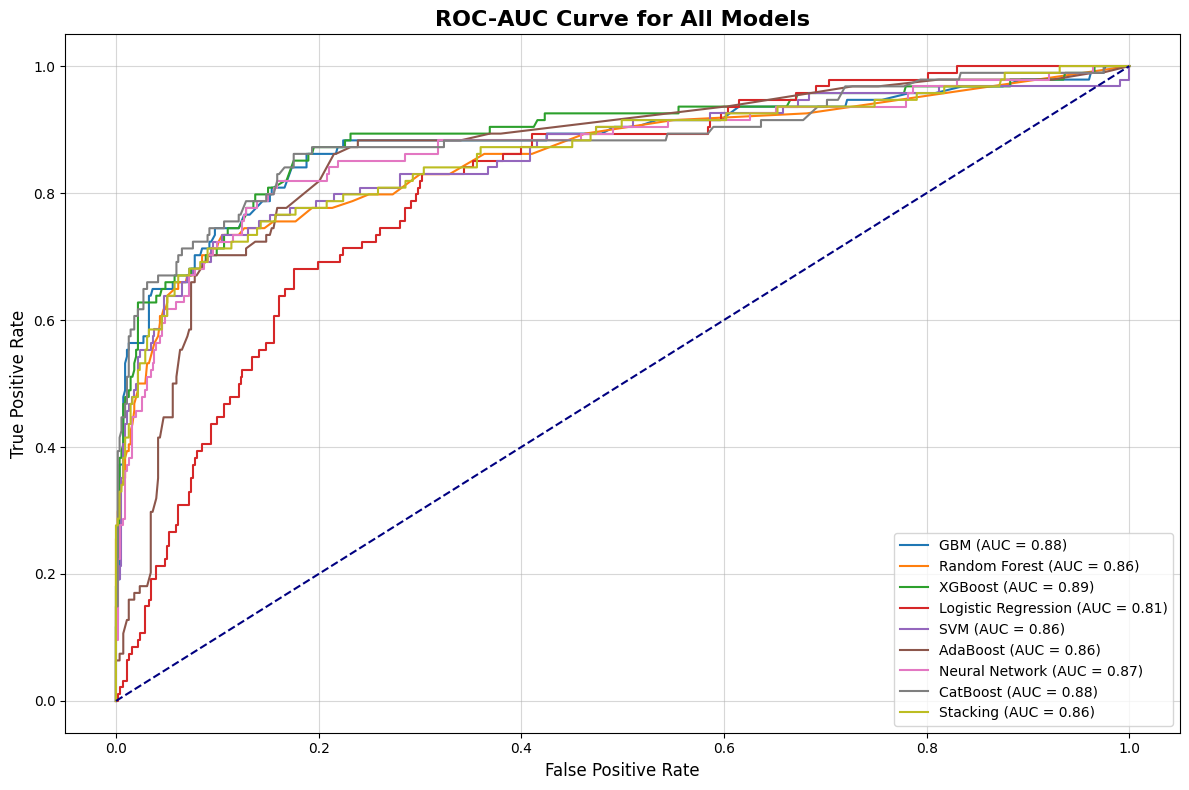

In [23]:
from sklearn.metrics import roc_curve, auc
# Function to plot ROC-AUC curve for each model
def plot_roc_auc(models, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(12, 8))

    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model.fit(X_train, y_train)  # Train the model
        
        if hasattr(model, "predict_proba"):  # Check if the model supports predict_proba
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):  # For SVM and similar models
            y_pred_proba = model.decision_function(X_test)
        else:
            print(f"Skipping {model_name} as it does not support probability predictions.")
            continue

        # Calculate ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        # Plot ROC Curve
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

    # Plot settings
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Diagonal line
    plt.title("ROC-AUC Curve for All Models", fontsize=16, fontweight="bold")
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

# Call the function to plot ROC-AUC curves
plot_roc_auc(models, X_train, y_train, X_test, y_test)

In [27]:
import joblib
import numpy as np
import warnings
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# In your training script
import joblib
import os

# Make sure models directory exists
os.makedirs('models', exist_ok=True)

# Train and save each model
for name, model in optimized_models.items():
    print(f"Training {name}...")
    X_train_arr = X_train.astype(np.float32)
    y_train_arr = y_train.astype(np.int32)
    
    model.fit(X_train_arr, y_train_arr)
    joblib.dump(model, f'models/{name}_model.joblib', protocol=3)
    print(f"{name} model saved successfully!")

# Save feature information
model_info = {
    'features': X_train.columns.tolist(),
    'feature_types': {col: str(np.dtype('float32')) for col in X_train.columns}
}
joblib.dump(model_info, 'models/model_info.joblib', protocol=3)

Training GBM...
GBM model saved successfully!
Training Random Forest...
Random Forest model saved successfully!
Training XGBoost...
XGBoost model saved successfully!
Training CatBoost...
CatBoost model saved successfully!
Training Stacking...
Stacking model saved successfully!


['models/model_info.joblib']